# Project - Deep Generative Models

In this project we will explore three main things:
1. The relationship between linear autoencoders and PCA.
2. Training Generative Adversarial Networks.
3. Using already-trained GANs.


**Remember to activate GPUs in Colab**.

## Implementing Autoencoders

In these exercises we will implement autoencoders in PyTorch.

In [ ]:
import warnings; 
warnings.simplefilter('ignore')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

mnist = MNIST('../data', train=True, download=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Exercise 1

Below you will find a boilerplate code for a Linear Autoencoder. We will use it on MNIST data, and compare with the result of reducing the dimensionality using PCA.

1. Fill the `self.encoder` and `self.decoder` to be linear layers from `28*28` to `2` and from `2` to `28*28` respectively. Implement the decoder to have a `sigmoid` activation function.
2. Define a `forward` function that represents the forward pass of the network: encode the input `x`, and then decode it to get `x_tilde`.
3. Why did we go for a `sigmoid` activation in the decoder?

The sigmoid function will make the output in the range between 0-1.

In [ ]:
class LinearAutoEncoder(nn.Module):
  def __init__(self):
    super(LinearAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(28 * 28, 2))
    self.decoder = nn.Sequential(
            nn.Linear(2, 28*28),
            nn.Sigmoid())

  def encode(self, x: torch.Tensor) -> torch.Tensor:
    return self.encoder(x)
  
  def decode(self, z: torch.Tensor) -> torch.Tensor:
    return self.decoder(z)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x_tilde = self.decoder(self.encoder(x))
    return x_tilde

In [ ]:
lae = LinearAutoEncoder()
print(lae)

LinearAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Exercise 2

Let's preprocess the `mnist.data`.
1. Call it `x`.
2. Normalize by dividing `x` by `255.0`.
3. How many digits are in `x`?
4. Reshape x to be `(x.shape[0], 28*28)`

In [ ]:
# 1
x = mnist

# 2
x = x.train_data.float() /255.

# 3
print(x.shape)

#4  
x = x.reshape(x.shape[0], 28*28)


torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
print(x.shape)

torch.Size([60000, 784])


### Exercise 3

Plot the first 3 digits using `plt.subplots`. Remember to use `.detach().numpy()` if you want to plot images using `matplotlib`.

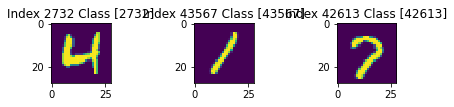

In [ ]:
# random check with nine training examples
np.random.seed(0);
indices = list(np.random.randint(x.shape[0],size=9)) # randomly selecting 9 examples
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x[indices[i]].reshape(28,28), interpolation='none')
    plt.title("Index {} Class {}".format(indices[i],[indices[i]]))
    plt.tight_layout()

### Exercise 4

Let's define the loss function for the training. In this case, use the **sum-of-squares reconstruction error**. Assume the inputs `x` and `x_prime` are flat vectors. (Hint. Check `MSELoss`)

In [ ]:
loss_f = nn.MSELoss()
def loss_function(x, x_prime) -> torch.Tensor:
  loss = loss_f(x, x_prime)
  return loss

### Exercise 5

Now we train:
1. Define your favorite optimizer, with your favorite learning rate.
2. Below you will find a boilerplate function for the `train` function. Fill in the blanks. We will overfit the model, since the goal here is to practice with AEs, not to get perfect reconstructions.
3. Run the `train` function on the `lae` model with the `data_loader` we defined, and 50 epochs.

In [ ]:
# Defining the things we will need.
dataset = TensorDataset(x)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lae = LinearAutoEncoder().to(device)

In [ ]:
lr = 0.01
optimizer = torch.optim.Adam(lae.parameters(), lr=lr)

In [ ]:
def train(model: LinearAutoEncoder, data_loader: DataLoader, optimizer: torch.optim.Optimizer, epochs: int):
  model.train()
  for epoch in range(epochs):
    if epoch % 10 == 0 or epoch == epochs - 1:
      print(f"Epoch: {epoch}", end=" ")

    running_epoch_loss = 0.0
    for batch in data_loader:
      x_batch = batch[0].to(device)

      # Reset the gradients to zero in the optimizer
      optimizer.zero_grad()

      # Do a forward pass of this batch on the model
      x_prime = model(x_batch)

      # Compute the loss
      loss = loss_function(x_batch, x_prime)
      running_epoch_loss += loss.item()

      # Propagate the loss backwards
      loss.backward()

      # Do a step in the optimizer
      optimizer.step()

    if epoch % 10 == 0 or epoch == epochs - 1:    
      print(f"loss: {running_epoch_loss / len(dataset)}")

In [ ]:
n_epochs = 50

train(lae, data_loader=data_loader, optimizer=optimizer, epochs=n_epochs)

Epoch: 0 loss: 0.0009846329662327965
Epoch: 10 loss: 0.000867789444886148
Epoch: 20 loss: 0.0008647642316296696
Epoch: 30 loss: 0.0008645386263728142
Epoch: 40 loss: 0.0008647093301638961
Epoch: 49 loss: 0.0008647113198414444


### Exercise 6

Let's print a number and it's reconstruction according to the AE:
1. Make a 2-figure subplot.
2. In one axis, plot the first digit `x[0].view(28, 28)`
3. In another, plot the reconstruction `lae(x[0]).view(28, 28)`.

**Warning**. You might need to use `.to(device)` when running on GPU, and `.cpu()` for plotting.

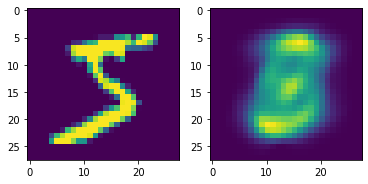

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x[0].view(28, 28))
axarr[1].imshow(lae(x[0].to(device)).view(28,28).tolist())

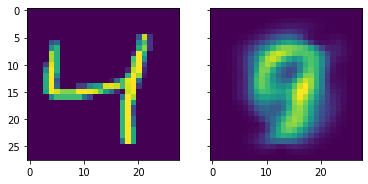

In [ ]:
_, (ax1,ax2) = plt.subplots(1,2,sharey=True)
ax1.imshow(x[2].view(28,28))
ax2.imshow((lae(x[2].to(device)).view(28,28)).tolist())

## A better Autoencoder

As you might have seen, the reconstructions of a linear autoencoder on MNIST are not great. In these three exercises we use the code we have already implemented to train a deeper non-linear autoencoder.

### Exercise 7

In the following you will find an implementation for an autoencoder with one hidden layer in each the encoder and decoder. Fill in the blanks. We leave it up to you to select the number for the amount of nodes in the hidden layers. Remember to add a sigmoid activation to the decoder (why?).

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    n_hidden = 256
    self.encoder = nn.Sequential(
      nn.Linear(28 * 28, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, 2)
    ) 

    self.decoder = nn.Sequential(
      nn.Linear(2, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, 28*28),
      nn.Sigmoid()
    ) 

  def encode(self, x: torch.Tensor) -> torch.Tensor:
    return self.encoder(x)
  
  def decode(self, z: torch.Tensor) -> torch.Tensor:
    return self.decoder(z)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x_tilde = self.decoder(self.encoder(x))
    return x_tilde

In [ ]:
ae = AutoEncoder().to(device)


print(ae)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


### Exercise 8

1. Create an optimizer of the parameters of your autoencoder `ae`.
2. Use the `train` function we defined above to train your autoencoder `ae`. Train for 50 epochs.

In [ ]:
# Defining the things we will need.
dataset = TensorDataset(x)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lae = LinearAutoEncoder().to(device)

ae_optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

In [ ]:
train(ae, data_loader=data_loader, optimizer=ae_optimizer, epochs=n_epochs)

Epoch: 0 loss: 0.000769730747739474
Epoch: 10 loss: 0.0006542096403737863
Epoch: 20 loss: 0.0006433127276599407
Epoch: 30 loss: 0.000639947643627723
Epoch: 40 loss: 0.0006368842825914422
Epoch: 49 loss: 0.0006358965530991554


### Exercise 9

Print the reconstruction of the first digit in a similar way as in exercise 6.

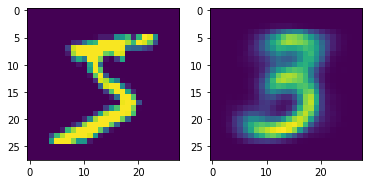

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x[0].view(28, 28))
axarr[1].imshow(ae(x[0].to(device)).view(28,28).tolist())

Slightly better, but still not great.

## Implementing a Generative Adversarial Network

In the following examples we will implement a Generative Adversarial Network to sample from the MNIST distribution.

### Exercise 10

1. If we want the discriminator to "classify" between real and fake, what would be an appropiate activation function?
2. In what follows we will create the two antagonist networks that compete in the minimax game we described in the slides. Fill in the blanks and keep into account the answer to 10.1.

In [ ]:
class GAN_Discriminator(nn.Module):
  def __init__(self):
    super(GAN_Discriminator, self).__init__()

    n_hidden = 256
    self.input_layer = nn.Sequential(
        nn.Linear(28*28, n_hidden),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(n_hidden, 1),
        nn.Sigmoid()
    )
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.output_layer(self.input_layer(x))

In [ ]:
D = GAN_Discriminator()
D

GAN_Discriminator(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
class GAN_Generator(nn.Module):
  def __init__(self):
    super(GAN_Generator, self).__init__()

    n_hidden = 256
    self.input_layer = nn.Sequential(
        nn.Linear(2, n_hidden),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(n_hidden, 28*28),
        nn.Sigmoid()
    )

  def forward(self, z: torch.Tensor) -> torch.Tensor:
    return self.output_layer(self.input_layer(z))

In [ ]:
G = GAN_Generator()
G

GAN_Generator(
  (input_layer): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

### Exercise 11

In what follows we will implement a `train_GAN` function that takes the two models `D` and `G` we defined above. Fill in the blanks.

In [ ]:
classification_loss = torch.nn.BCELoss()

def train_GAN(
    D: GAN_Discriminator,
    G: GAN_Generator,
    opt_D: torch.optim.Optimizer,
    opt_G: torch.optim.Optimizer,
    data_loader: DataLoader,
    epochs: int
  ):
  for epoch in range(epochs):
    running_loss_D, running_loss_G = 0.0, 0.0
    for real_batch, in data_loader:
      real_batch = real_batch.to(device)
      
      # Getting random zs
      batch_size, _ = real_batch.shape

      ##! Create a random vector of shape (batch_size, 2), finish with .to(device) 
      random_z = torch.rand(batch_size,2).to(device)

      # Minimizing w.r.t. D
      D.train()
      opt_D.zero_grad()

      ## Computing the Discriminator at both
      D_at_x = D(real_batch)
      G_at_z = G(random_z)

      ### Correctly classifying the real ones
      loss_D_reals = classification_loss(
          D_at_x,
          torch.ones(batch_size, 1).to(device)
      )

      ### Correctly classifying the fake ones
      loss_D_fakes = classification_loss(
          D(G_at_z.detach()),
          torch.zeros(batch_size, 1).to(device)
      )

      ##! Take the average of loss_D_reals and loss_D_fakes
      #loss_D = loss_function(loss_D_reals, loss_D_fakes)
      loss_D = (loss_D_reals + loss_D_fakes) / 2

      ##! Optimizer step. Fill in the blanks.
      running_loss_D += loss_D.item()
      loss_D.backward()
      opt_D.step()

      D.eval()

      # Maximizing w.r.t G
      G.train()
      opt_G.zero_grad()

      ## Computing fakes with G.
      G_at_z = G(random_z)

      ## Computing the missclassification of the Discriminator
      loss_G = classification_loss(
          D(G_at_z),
          torch.ones(batch_size, 1).to(device)
      )
      
      ##! Optimizer step. Fill in the blanks
      running_loss_G += loss_G.item()
      loss_G.backward()
      opt_G.step()

      G.eval()

    # Printing utilities. Don't worry about this.
    if epoch % 10 == 0 or epoch == epochs - 1:
      print(f"Epoch {epoch}, loss D: {running_loss_D/len(data_loader):.5f}, loss G: {running_loss_G/len(data_loader):.5f}")
      print("Random samples:")
      _, axes = plt.subplots(1, 3)
      for fake_img, ax in zip(G_at_z, axes):
        ax.axis("off")
        img = fake_img.view(28, 28).cpu().detach().numpy()
        ax.imshow(img, vmin=0, vmax=1)

      plt.show()
      plt.close()

We will train this GAN for 100 epochs.
1. Start by defining instances of our generator and discriminator (remember to use `.to(device)`)
2. Define two optimizers (one for each network), and set a learning rate less than or equal to `0.001`.
3. Run the `train_GAN` function with 100 epochs.

Epoch 0, loss D: 0.04575, loss G: 6.20434
Random samples:


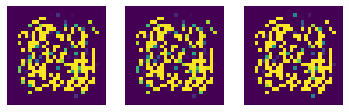

Epoch 10, loss D: 0.00326, loss G: 9.31827
Random samples:


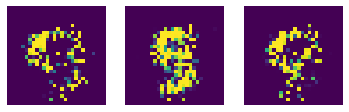

Epoch 20, loss D: 0.00091, loss G: 20.65652
Random samples:


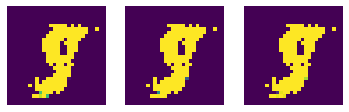

Epoch 30, loss D: 0.00000, loss G: 54.46499
Random samples:


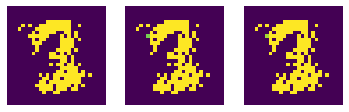

Epoch 40, loss D: 0.00000, loss G: 53.99581
Random samples:


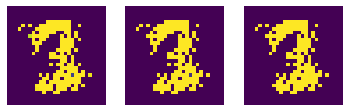

Epoch 50, loss D: 0.00000, loss G: 52.48593
Random samples:


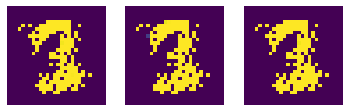

Epoch 60, loss D: 0.00000, loss G: 52.12497
Random samples:


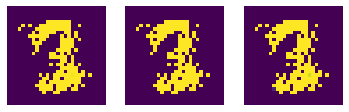

Epoch 70, loss D: 0.00000, loss G: 52.09284
Random samples:


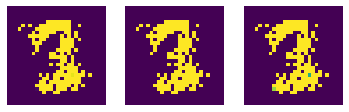

Epoch 80, loss D: 0.00000, loss G: 52.06029
Random samples:


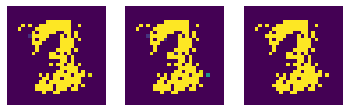

Epoch 90, loss D: 0.00000, loss G: 52.02449
Random samples:


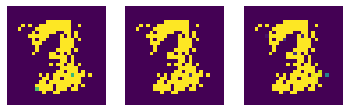

Epoch 99, loss D: 0.00000, loss G: 51.99273
Random samples:


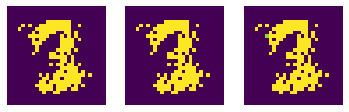

In [ ]:
dataset = TensorDataset(x)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 100
lr = 0.001

D = GAN_Discriminator().to(device)
G = GAN_Generator().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr)


train_GAN(D, G, opt_D, opt_G, data_loader, n_epochs)

### Exercise 12

1. Get a random vector `z` of shape `(1000, 2)` using `torch.randn`.
2. Get the generated images for said `z` using our generator `G`.
3. Plot them in the latent space using the auxiliary function we provide.

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_images(z: torch.Tensor, fakes: torch.Tensor):
  """
  Plots the fake images in {fakes} at positions {z}.
  """
  _, ax = plt.subplots(1, 1)

  z = z.cpu().detach().numpy()
  images = fakes.view(fakes.shape[0], 28, 28)
  images = images.cpu().detach().numpy()

  for zi, img in zip(z, images):
    im = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(im, zi, xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim([zi])
    ax.autoscale()

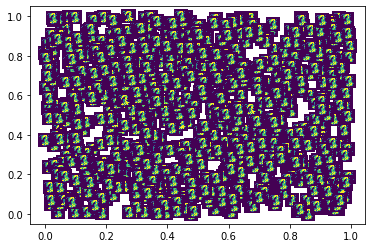

In [ ]:
z = torch.rand(1000,2).to(device)
fakes = G(z)
plot_images(z, fakes)